In [7]:
import numpy as np

from scipy.optimize import curve_fit
import scipy.ndimage as ndimage
from scipy.io import loadmat
from ImageProcessing import *

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers

from ImageProcessing import *
from ImageGenerator import ImageGenerator
from ImageClassifier import *

# Loading Data

In [55]:
data = loadmat('camera,fIdx=3354809,bx0_V=-0.068000000,by0_V=-0.230000000,bz0_V=0.020000000,imagingDetuning0_MHz=-0.600000000,cameraExposureTime=0.005000000,iterator=20.000000000')
n_loops = 20
stack = data['stack']

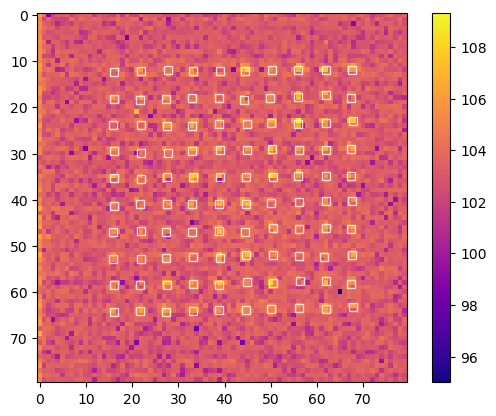

In [56]:
processor = GreenImageProcessor(stack, 100, 20)
processor.plot()

In [5]:
crops = processor.crop_tweezer(3)
plt.imshow(crops[0])

AttributeError: module 'matplotlib' has no attribute 'imshow'

# Creating Labels with Thresholding Algorithm

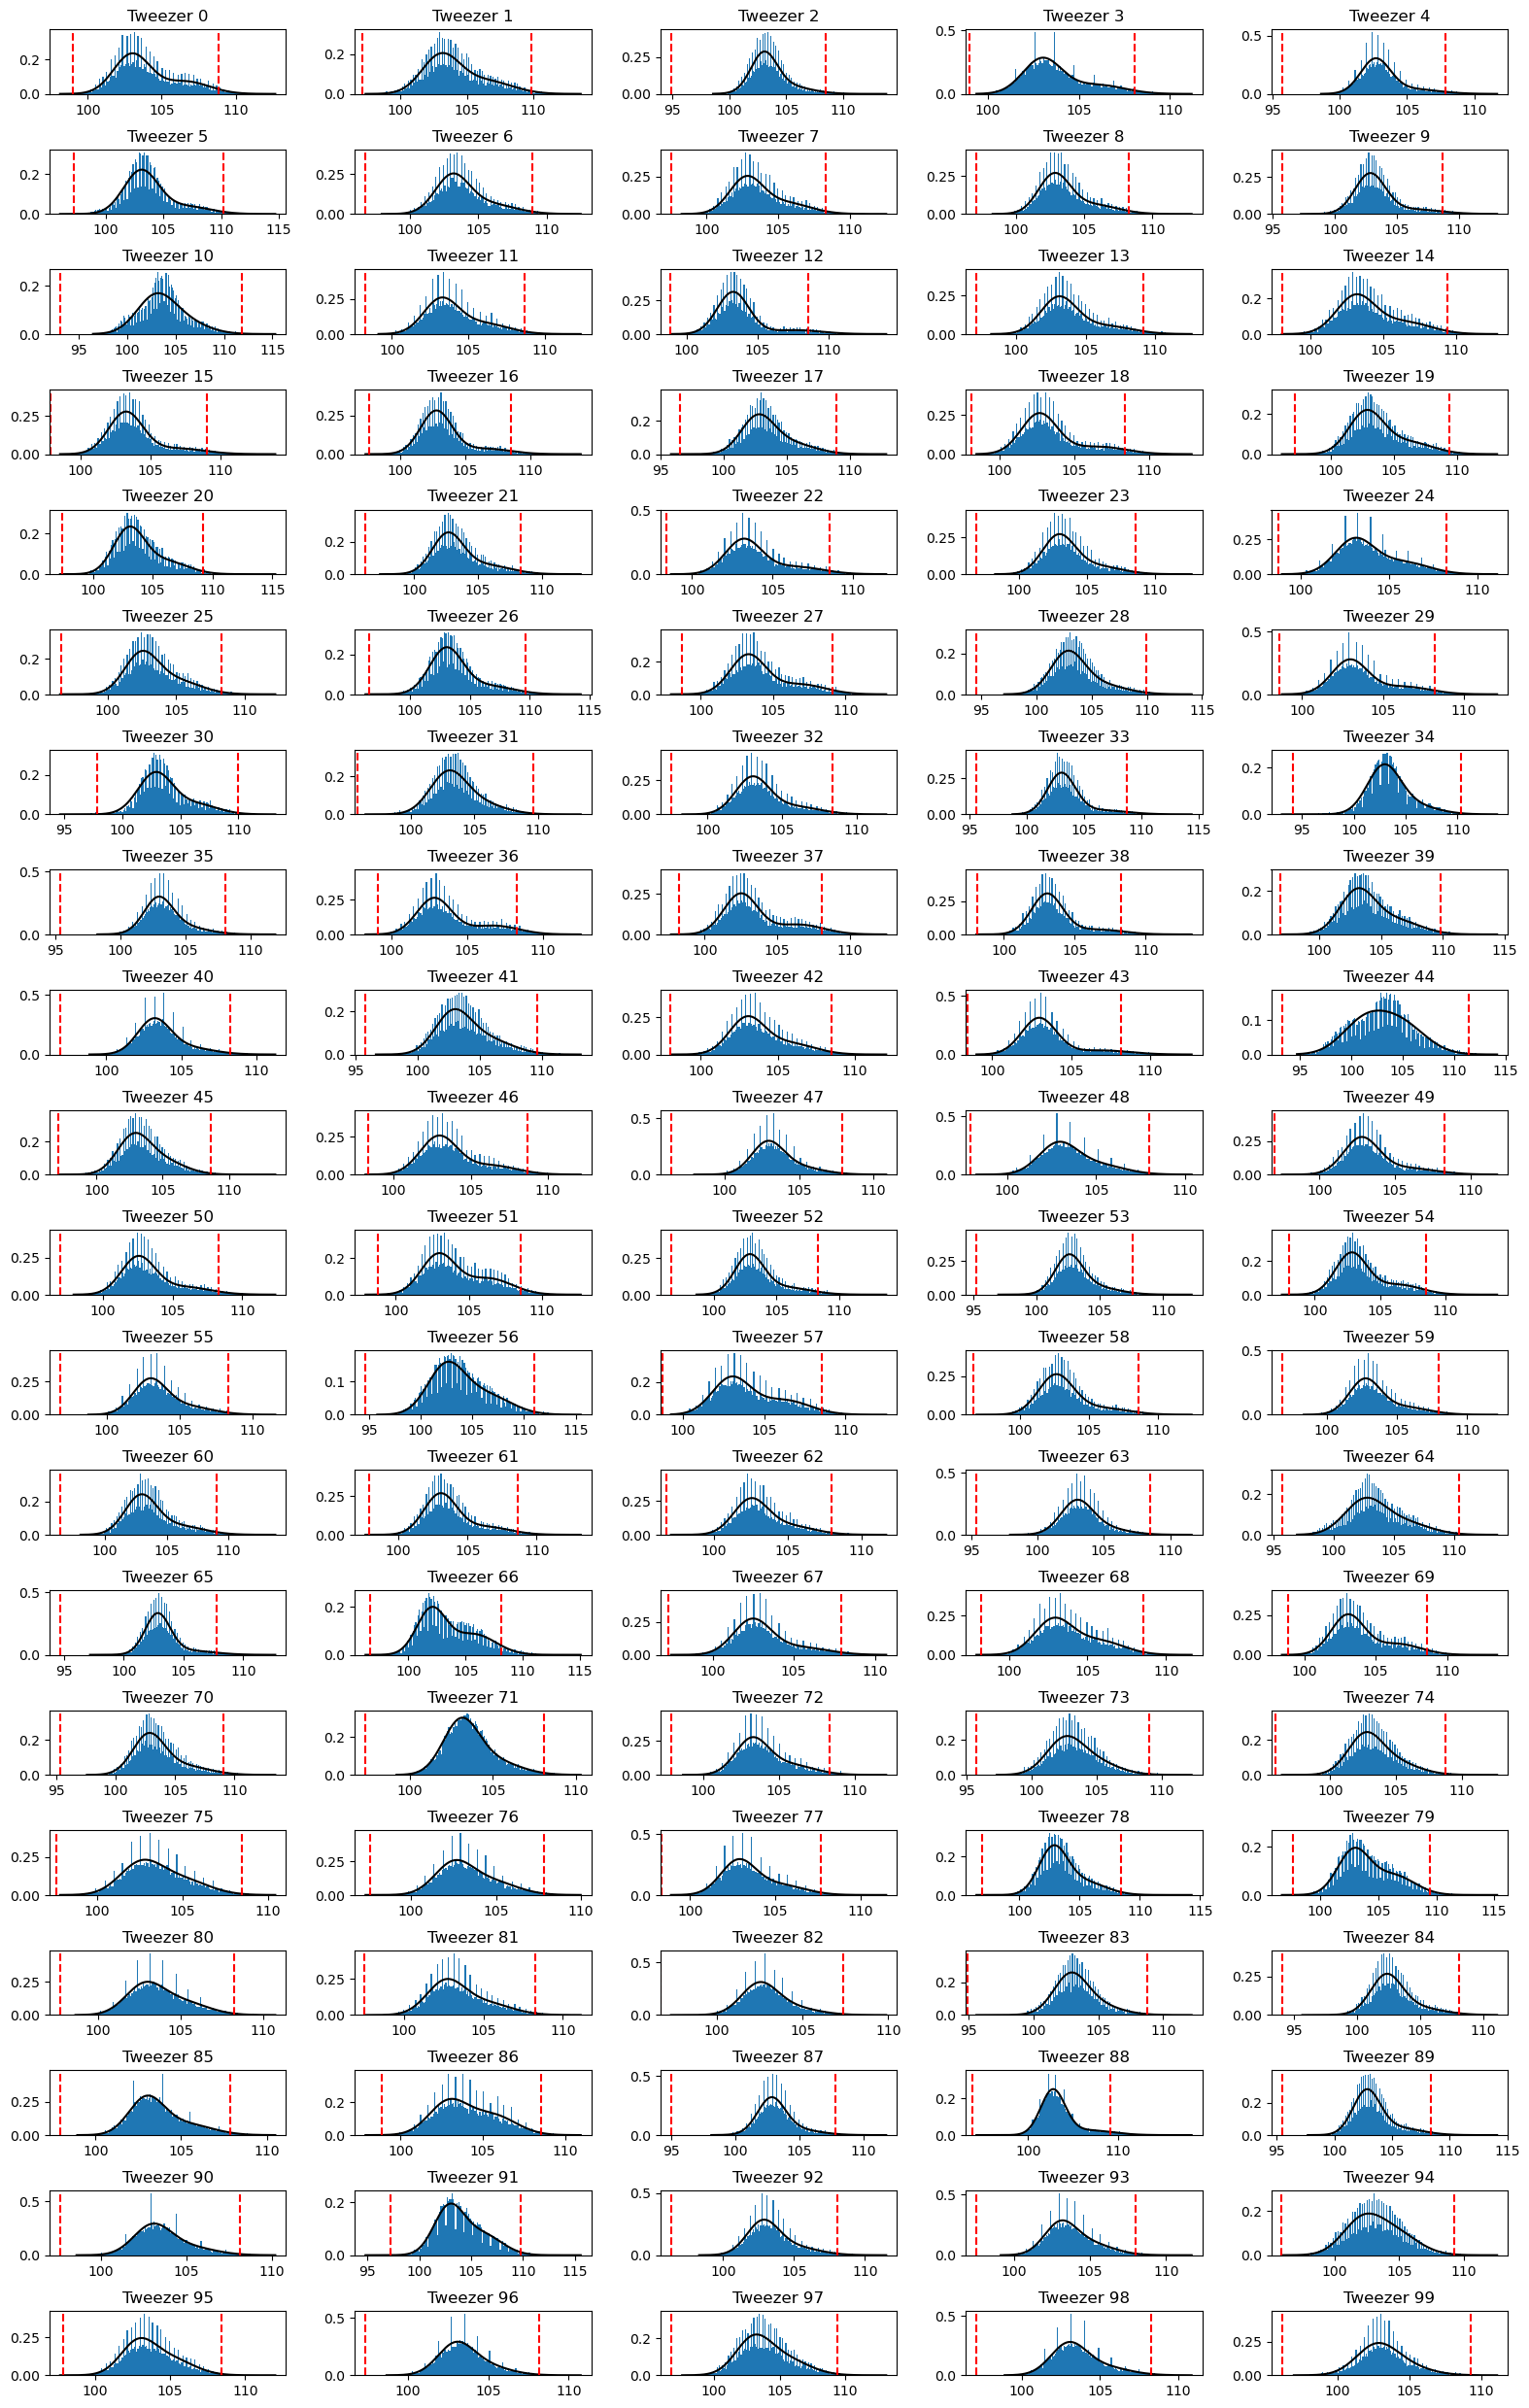

In [40]:
crops, labels = processor.make_dataset(1, keep_unknowns=True, plot=True)

In [41]:
labels, thresholds = processor.make_labels_v2()

9277


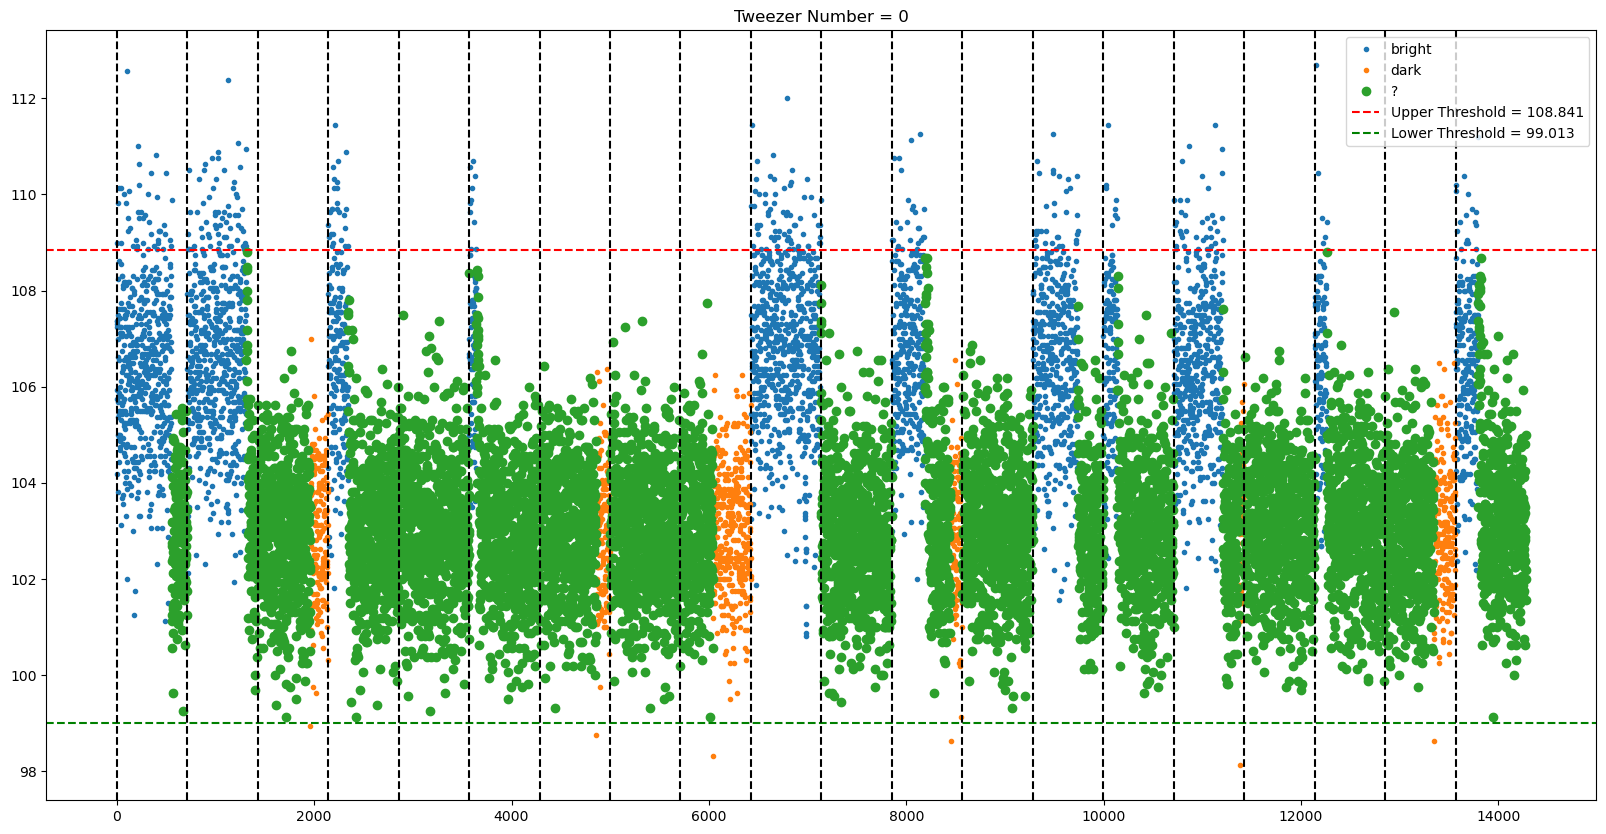

In [42]:
import matplotlib.pyplot as plt
tweezer = 0

tweezer_vals = np.mean(crops[processor.crop_index(tweezer, 0, 0): processor.crop_index(tweezer + 1, 0, 0)], axis=(1, 2))
tweezer_labels = labels[processor.crop_index(tweezer, 0, 0): processor.crop_index(tweezer + 1, 0, 0)]

bright_mask = tweezer_labels[:, 1] == 1
dark_mask = tweezer_labels[:, 0] == 1
unknown_mask = np.isnan(tweezer_labels[:, 0])

bright_indices = np.where(bright_mask)[0]
bright_vals = tweezer_vals[bright_mask]

dark_indices = np.where(dark_mask)[0]
dark_vals = tweezer_vals[dark_mask]

unknown_indices = np.where(unknown_mask)[0]
unknown_vals = tweezer_vals[unknown_mask]

print(len(unknown_vals))
plt.figure(figsize=(20, 10))
plt.plot(bright_indices, bright_vals, '.', label='bright')
plt.plot(dark_indices, dark_vals, '.', label='dark')
plt.plot(unknown_indices, unknown_vals, 'o', label='?')
plt.axhline(thresholds[tweezer, 1], color='r', linestyle='--', label=f"Upper Threshold = {thresholds[tweezer, 1]:.3f}")
plt.axhline(thresholds[tweezer, 0], color='g', linestyle='--', label=f"Lower Threshold = {thresholds[tweezer, 0]:.3f}")
plt.legend()
plt.title(f"Tweezer Number = {tweezer}")
for i in range(n_loops):
    plt.axvline(i * processor.per_loop, color='k', linestyle='--', label="Loop Separation")
plt.show()

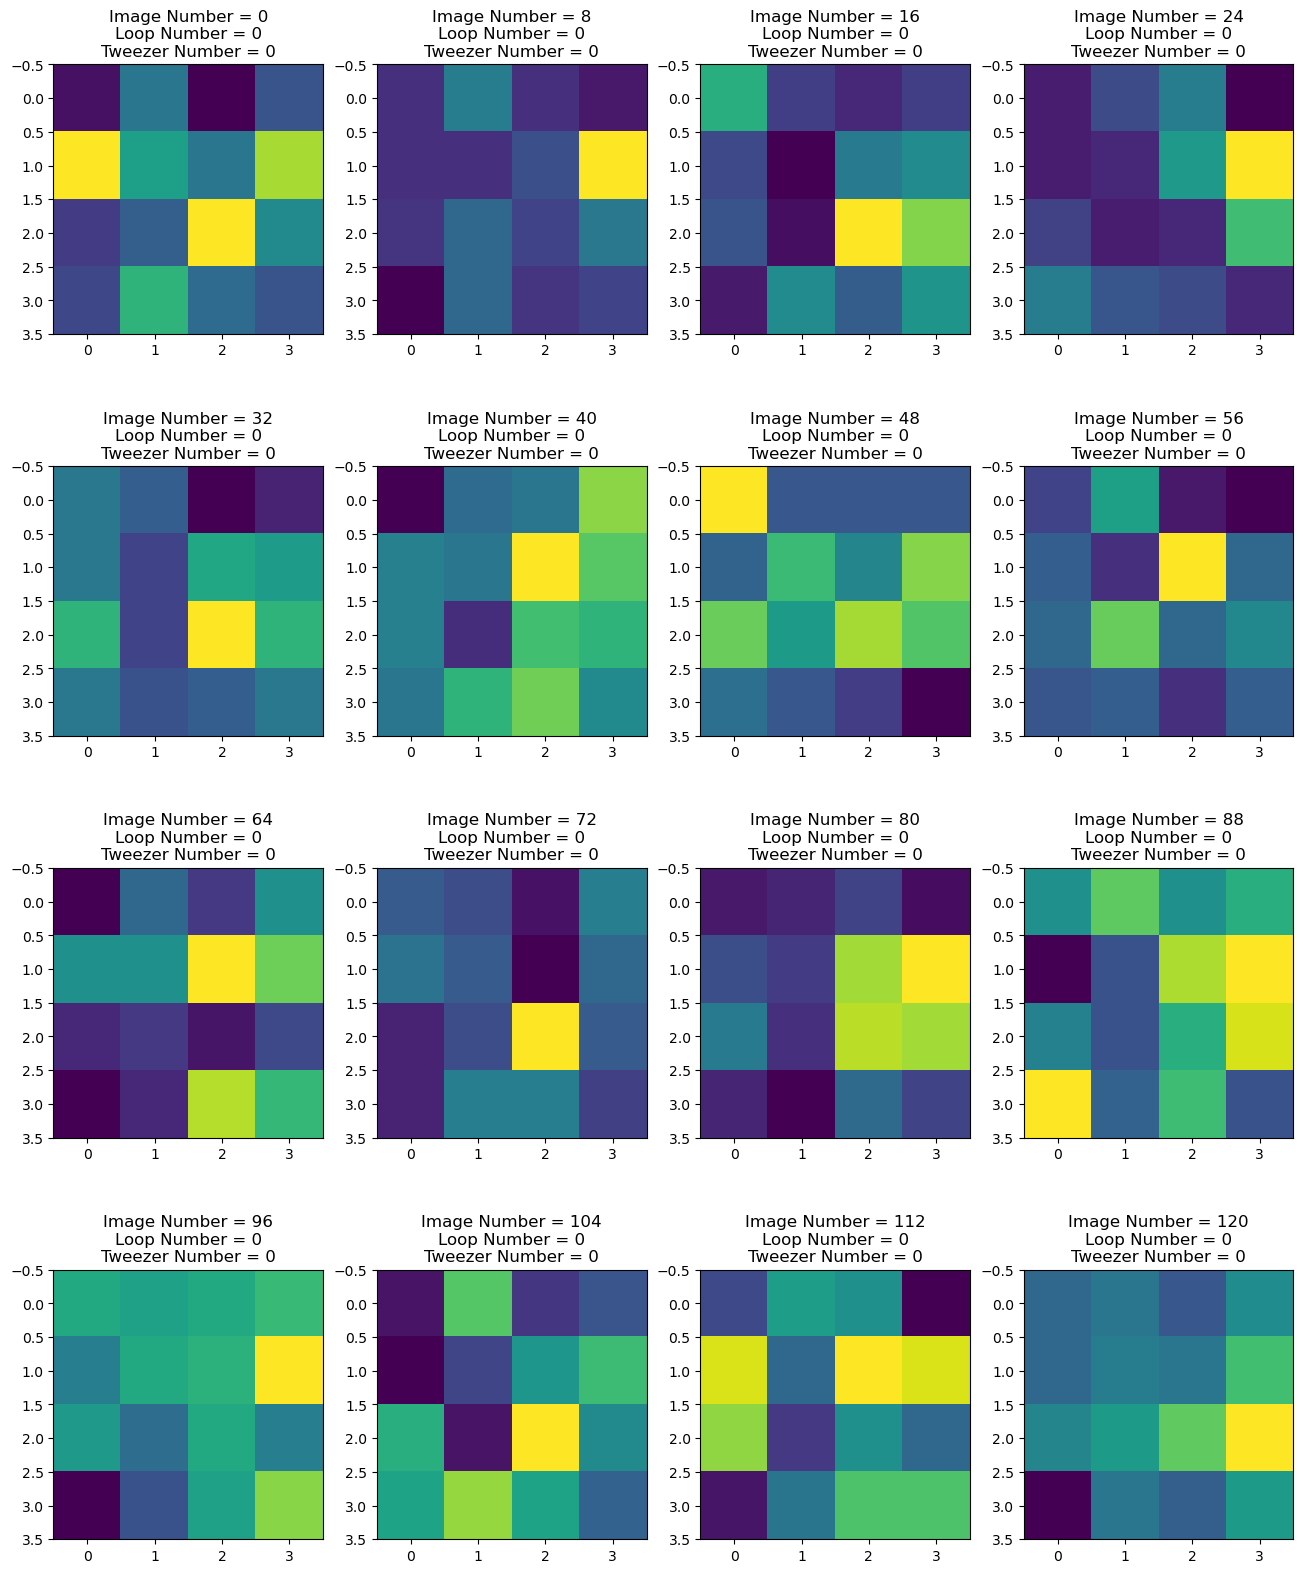

In [44]:
#i, j, k = np.random.randint(processor.n_tweezers), np.random.randint(processor.n_loops), np.random.randint(processor.per_loop - 4)
loop = 0

fig, axs = plt.subplots(4, 4, figsize=(16, 20))

for n in range(16):
    axs[n // 4, np.mod(n, 4)].imshow(crops[processor.crop_index(tweezer, loop, 8 * n)])
    axs[n // 4, np.mod(n, 4)].set_title(f"Image Number = {8 * n}\nLoop Number = {loop}\nTweezer Number = {tweezer}")

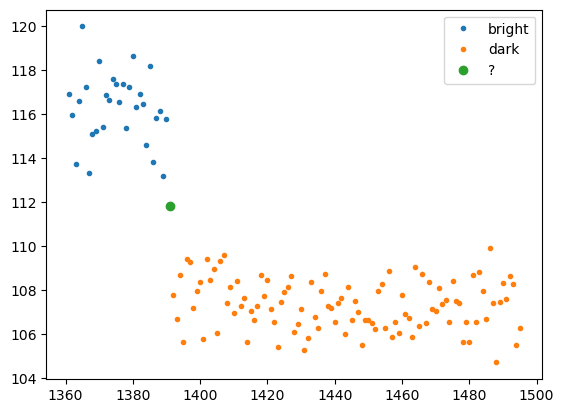

In [16]:
loop_num = 10
low = processor.per_loop * loop_num
high = processor.per_loop * (loop_num + 1)
bright_mask = (low < bright_indices) & (bright_indices < high)
dark_mask = (low < dark_indices) & (dark_indices < high)
unknown_mask = (low < unknown_indices) & (unknown_indices < high)

plt.plot(bright_indices[bright_mask], bright_vals[bright_mask], '.', label='bright')
plt.plot(dark_indices[dark_mask], dark_vals[dark_mask], '.', label='dark')
plt.plot(unknown_indices[unknown_mask], unknown_vals[unknown_mask], 'o', label='?')
#plt.axhline(upper_threshold, color='r', linestyle='--')
#plt.axhline(lower_threshold, color='r', linestyle='--')
plt.legend()
plt.show()

# Making Training and Testing Datasets

In [20]:
data = loadmat('jun1_run9.mat')
n_loops = 20
lattice_shape = np.array([10, 10])
test_stack = data['stack']

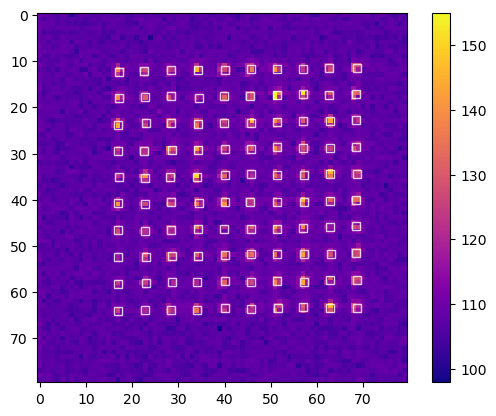

In [57]:
testing_processor = GreenImageProcessor(test_stack, 100, 20)
testing_processor.plot()

In [60]:
training_images, training_labels = processor.make_dataset(keep_unknowns=True)
testing_images, testing_labels = testing_processor.make_dataset()

[nan nan]


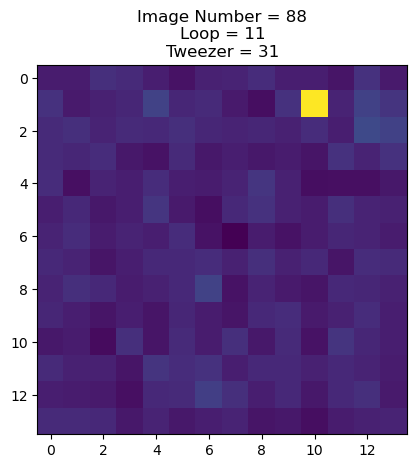

In [87]:
i, j, k = np.random.randint(processor.n_tweezers), np.random.randint(processor.n_loops), np.random.randint(processor.per_loop)
plt.imshow(training_images[processor.crop_index(i, j, k)])
plt.title(f"Image Number = {k}\nLoop = {j}\nTweezer = {i}")
plt.plot()
print(training_labels[processor.crop_index(i, j, k)])

# Neural Network Models

In [ ]:
networks = [models.Sequential() for i in range(4)]

In [ ]:
networks[0] = models.Sequential()
networks[0].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[0].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[0].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[0].add(layers.Flatten())
networks[0].add(layers.Dense(2, activation='sigmoid'))

networks[0].summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 1,106
Trainable params: 1,106
Non-trainable params: 0
_________________________________________________________________


In [ ]:
networks[1] = models.Sequential()
networks[1].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[1].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[1].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[1].add(layers.Flatten())
networks[1].add(layers.Dense(2, activation='sigmoid'))

networks[1].summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 8)         80        
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 8)         584       
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 3138      
                                                                 
Total params: 3,802
Trainable params: 3,802
Non-trainable params: 0
_________________________________________________________________


In [ ]:
networks[2] = models.Sequential()
networks[2].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[2].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[2].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[2].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[2].add(layers.Flatten())
networks[2].add(layers.Dense(2, activation='sigmoid'))

networks[2].summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 16, 16, 8)         80        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 8)           584       
                                                                 
 flatten_2 (Flatten)         (None, 288)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 578       
                                                                 
Total params: 1,242
Trainable params: 1,242
Non-trainable params: 0
____________________________________________________

In [ ]:
networks[3] = models.Sequential()
networks[3].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[3].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[3].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[3].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[3].add(layers.Flatten())
networks[3].add(layers.Dense(9, activation='sigmoid'))
networks[3].add(layers.Dense(2, activation='sigmoid'))

networks[3].summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 16, 16, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 8)           584       
                                                                 
 flatten_3 (Flatten)         (None, 288)               0         
                                                                 
 dense_3 (Dense)             (None, 9)                 2601      
                                                                 
 dense_4 (Dense)             (None, 2)                 20        
                                                      

In [ ]:
histories = []
for net in networks:
    net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    histories.append(net.fit(training_images, training_labels, epochs=8))

Epoch 1/8
8341/8341 [==============================] - 20s 2ms/step - loss: 0.1002 - binary_accuracy: 0.9768
Epoch 2/8
8341/8341 [==============================] - 19s 2ms/step - loss: 0.0111 - binary_accuracy: 0.9968
Epoch 3/8
8341/8341 [==============================] - 19s 2ms/step - loss: 0.0093 - binary_accuracy: 0.9974
Epoch 4/8
8341/8341 [==============================] - 19s 2ms/step - loss: 0.0088 - binary_accuracy: 0.9976
Epoch 5/8
8341/8341 [==============================] - 19s 2ms/step - loss: 0.0085 - binary_accuracy: 0.9977
Epoch 6/8
8341/8341 [==============================] - 20s 2ms/step - loss: 0.0085 - binary_accuracy: 0.9976
Epoch 7/8
8341/8341 [==============================] - 19s 2ms/step - loss: 0.0082 - binary_accuracy: 0.9978
Epoch 8/8
8341/8341 [==============================] - 19s 2ms/step - loss: 0.0081 - binary_accuracy: 0.9978
Epoch 1/8
8341/8341 [==============================] - 42s 5ms/step - loss: 0.0178 - binary_accuracy: 0.9943
Epoch 2/8
8341/8341

In [ ]:
networks[3].compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
histories[3] = networks[3].fit(training_images, training_labels, epochs=8)

Epoch 1/8
2060/8341 [======>.......................] - ETA: 23s - loss: 0.0073 - binary_accuracy: 0.9982

KeyboardInterrupt: 

In [ ]:
for i, his in enumerate(histories):
    plt.plot(his.history['loss'], label=f"Model {i}")
plt.title("Loss Over Duration of Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: name 'histories' is not defined

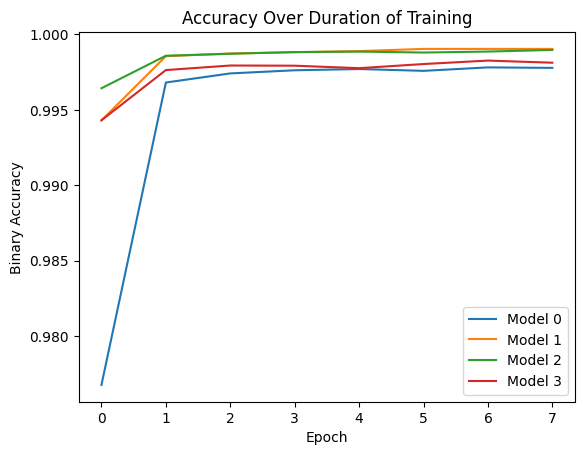

In [ ]:
for i, his in enumerate(histories):
    plt.plot(his.history['binary_accuracy'], label=f"Model {i}")
plt.title("Accuracy Over Duration of Training")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.legend()
plt.show()

In [ ]:
for net in networks:
    net.evaluate(testing_images, testing_labels)

4711/4711 [==============================] - 6s 1ms/step - loss: 0.0332 - binary_accuracy: 0.9930


In [ ]:
# Network 2 wins!
best = networks[2]

In [ ]:
networks = [models.Sequential() for i in range(4)]
histories = []

for net in networks:
    net.add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
    net.add(layers.Conv2D(6 + 2 * i, (3, 3), strides=1, activation='relu'))
    net.add(layers.MaxPooling2D(pool_size=(2, 2)))
    net.add(layers.Conv2D(6 + 2 * i, (3, 3), strides=1, activation='relu'))
    net.add(layers.Flatten())
    net.add(layers.Dense(2, activation='sigmoid'))

In [ ]:
for net in networks:    
    net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    histories.append(net.fit(training_images, training_labels, epochs=8))

Epoch 1/8
8346/8346 [==============================] - 30s 4ms/step - loss: 0.0419 - binary_accuracy: 0.9908
Epoch 2/8
8346/8346 [==============================] - 29s 3ms/step - loss: 0.0260 - binary_accuracy: 0.9952
Epoch 3/8
8346/8346 [==============================] - 30s 4ms/step - loss: 0.0236 - binary_accuracy: 0.9958
Epoch 4/8
8346/8346 [==============================] - 28s 3ms/step - loss: 0.0229 - binary_accuracy: 0.9960
Epoch 5/8
8346/8346 [==============================] - 32s 4ms/step - loss: 0.0224 - binary_accuracy: 0.9961
Epoch 6/8
8346/8346 [==============================] - 30s 4ms/step - loss: 0.0219 - binary_accuracy: 0.9962
Epoch 7/8
8346/8346 [==============================] - 29s 3ms/step - loss: 0.0215 - binary_accuracy: 0.9962
Epoch 8/8
8346/8346 [==============================] - 29s 3ms/step - loss: 0.0219 - binary_accuracy: 0.9963
Epoch 1/8
8346/8346 [==============================] - 30s 4ms/step - loss: 0.0424 - binary_accuracy: 0.9907
Epoch 2/8
8346/8346

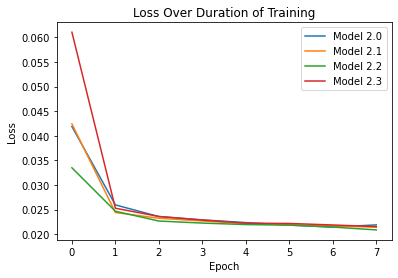

In [ ]:
for i, his in enumerate(histories):
    plt.plot(his.history['loss'], label=f"Model 2.{i}")
plt.title("Loss Over Duration of Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

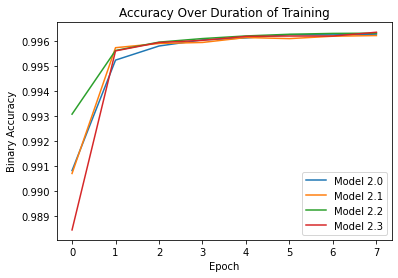

In [ ]:
for i, his in enumerate(histories):
    plt.plot(his.history['binary_accuracy'], label=f"Model 2.{i}")
plt.title("Accuracy Over Duration of Training")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.legend()
plt.show()

In [ ]:
for net in networks:
    net.evaluate(testing_images, testing_labels)

4160/4160 [==============================] - 7s 2ms/step - loss: 0.0207 - binary_accuracy: 0.9946


In [ ]:
networks = [models.Sequential() for i in range(4)]
histories = []

networks[0] = models.Sequential()
networks[0].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[0].add(layers.Conv2D(10, (3, 3), strides=1, activation='relu'))
networks[0].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[0].add(layers.Conv2D(10, (3, 3), strides=1, activation='relu'))
networks[0].add(layers.Flatten())
networks[0].add(layers.Dense(2, activation='sigmoid'))

networks[1] = models.Sequential()
networks[1].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[1].add(layers.Conv2D(10, (5, 5), strides=1, activation='relu'))
networks[1].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[1].add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
networks[1].add(layers.Flatten())
networks[1].add(layers.Dense(2, activation='sigmoid'))

networks[2] = models.Sequential()
networks[2].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[2].add(layers.Conv2D(10, (3, 3), strides=1, activation='relu'))
networks[2].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[2].add(layers.Conv2D(10, (5, 5), strides=1, activation='relu'))
networks[2].add(layers.Flatten())
networks[2].add(layers.Dense(2, activation='sigmoid'))

networks[3] = models.Sequential()
networks[3].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[3].add(layers.Conv2D(10, (5, 5), strides=1, activation='relu'))
networks[3].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[3].add(layers.Conv2D(10, (5, 5), strides=1, activation='relu'))
networks[3].add(layers.Flatten())
networks[3].add(layers.Dense(2, activation='sigmoid'))


In [ ]:
histories = []
for net in networks:    
    net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    histories.append(net.fit(training_images, training_labels, epochs=8))

Epoch 1/8
8346/8346 [==============================] - 30s 4ms/step - loss: 0.0426 - binary_accuracy: 0.9896
Epoch 2/8
8346/8346 [==============================] - 28s 3ms/step - loss: 0.0248 - binary_accuracy: 0.9954
Epoch 3/8
8346/8346 [==============================] - 35s 4ms/step - loss: 0.0223 - binary_accuracy: 0.9957
Epoch 4/8
8346/8346 [==============================] - 29s 3ms/step - loss: 0.0208 - binary_accuracy: 0.9959
Epoch 5/8
8346/8346 [==============================] - 32s 4ms/step - loss: 0.0204 - binary_accuracy: 0.9958
Epoch 6/8
8346/8346 [==============================] - 34s 4ms/step - loss: 0.0197 - binary_accuracy: 0.9959
Epoch 7/8
8346/8346 [==============================] - 32s 4ms/step - loss: 0.0200 - binary_accuracy: 0.9959
Epoch 8/8
8346/8346 [==============================] - 32s 4ms/step - loss: 0.0195 - binary_accuracy: 0.9960
Epoch 1/8
8346/8346 [==============================] - 38s 4ms/step - loss: 0.0536 - binary_accuracy: 0.9890
Epoch 2/8
8346/8346

In [ ]:
networks[3] = models.Sequential()
networks[3].add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
networks[3].add(layers.Conv2D(10, (5, 5), strides=1, activation='relu'))
networks[3].add(layers.MaxPooling2D(pool_size=(2, 2)))
networks[3].add(layers.Conv2D(10, (5, 5), strides=1, activation='relu'))
networks[3].add(layers.Flatten())
networks[3].add(layers.Dense(2, activation='sigmoid'))

networks[3].compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
histories[3] = networks[3].fit(training_images, training_labels, epochs=8)

Epoch 1/8
8346/8346 [==============================] - 32s 4ms/step - loss: 0.0541 - binary_accuracy: 0.9895
Epoch 2/8
8346/8346 [==============================] - 33s 4ms/step - loss: 0.0271 - binary_accuracy: 0.9952
Epoch 3/8
8346/8346 [==============================] - 31s 4ms/step - loss: 0.0270 - binary_accuracy: 0.9952
Epoch 4/8
8346/8346 [==============================] - 31s 4ms/step - loss: 0.0251 - binary_accuracy: 0.9956
Epoch 5/8
8346/8346 [==============================] - 29s 4ms/step - loss: 0.0240 - binary_accuracy: 0.9958
Epoch 6/8
8346/8346 [==============================] - 34s 4ms/step - loss: 0.0235 - binary_accuracy: 0.9958
Epoch 7/8
8346/8346 [==============================] - 33s 4ms/step - loss: 0.0234 - binary_accuracy: 0.9958
Epoch 8/8
8346/8346 [==============================] - 35s 4ms/step - loss: 0.0230 - binary_accuracy: 0.9959


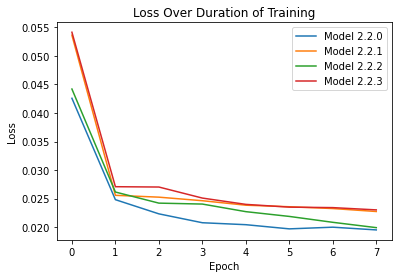

In [ ]:
for i, his in enumerate(histories):
    plt.plot(his.history['loss'], label=f"Model 2.2.{i}")
plt.title("Loss Over Duration of Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
for i, his in enumerate(histories):
    plt.plot(his.history['binary_accuracy'], label=f"Model 2.2.{i}")
plt.title("Accuracy Over Duration of Training")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.legend()
plt.show()

NameError: name 'histories' is not defined

In [ ]:
for net in networks:
    net.evaluate(testing_images, testing_labels)

4160/4160 [==============================] - 6s 1ms/step - loss: 0.0326 - binary_accuracy: 0.9897


# Optimal network from first round of testing

In [ ]:
network = models.Sequential()
network.add(layers.Input(shape=(training_images.shape[1], training_images.shape[2], 1)))
network.add(layers.Conv2D(10, (3, 3), strides=1, activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2)))
network.add(layers.Conv2D(10, (3, 3), strides=1, activation='relu'))
network.add(layers.Flatten())
network.add(layers.Dense(2, activation='sigmoid'))

network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
network.fit(training_images, training_labels, epochs=8)

Epoch 1/8
8341/8341 [==============================] - 33s 4ms/step - loss: 0.0398 - binary_accuracy: 0.9921
Epoch 2/8
8341/8341 [==============================] - 33s 4ms/step - loss: 0.0056 - binary_accuracy: 0.9984
Epoch 3/8
8341/8341 [==============================] - 29s 3ms/step - loss: 0.0046 - binary_accuracy: 0.9987
Epoch 4/8
8341/8341 [==============================] - 32s 4ms/step - loss: 0.0048 - binary_accuracy: 0.9986
Epoch 5/8
8341/8341 [==============================] - 32s 4ms/step - loss: 0.0048 - binary_accuracy: 0.9986
Epoch 6/8
8341/8341 [==============================] - 32s 4ms/step - loss: 0.0049 - binary_accuracy: 0.9986
Epoch 7/8
8341/8341 [==============================] - 32s 4ms/step - loss: 0.0042 - binary_accuracy: 0.9988
Epoch 8/8
8341/8341 [==============================] - 32s 4ms/step - loss: 0.0043 - binary_accuracy: 0.9988


In [ ]:
network.evaluate(testing_images, testing_labels)

5625/5625 [==============================] - 7s 1ms/step - loss: nan - binary_accuracy: 0.8338


[nan, 0.8337583541870117]

# Fidelity Analysis

In [ ]:
classifier = ImageClassifier(network)
fidelities = classifier.get_fidelity(testing_images, 100, 20)

5625/5625 [==============================] - 6s 1ms/step


AxisError: axis 2 is out of bounds for array of dimension 2

In [ ]:
labels = np.rint(network.predict(testing_images))

5625/5625 [==============================] - 7s 1ms/step


In [ ]:
def get_fidelity(labels, n_tweezers, n_loops):
    """ Return probability of bright to dark and dark to bright of each tweezer. """
    labels = np.reshape(labels[:, 1], (n_tweezers, n_loops, -1))
    first_diff = np.diff(labels, axis=2)
    n_dark_to_bright = np.sum(first_diff == -1, axis=(1, 2))
    n_dark = np.sum(labels[:,:,:-1] == 0, axis=(1, 2))
    n_bright_to_dark = np.sum(first_diff == 1, axis=(1, 2))
    n_bright = np.sum(labels[:,:,:-1] == 1, axis=(1, 2))
    return n_dark_to_bright / n_dark, n_bright_to_dark / n_bright

In [ ]:
pdb, pbd = get_fidelity(labels, 100, 20)

Average probability of dark to bright: 0.010067457798605756
Average probability of bright to dark: 0.011461610075288998


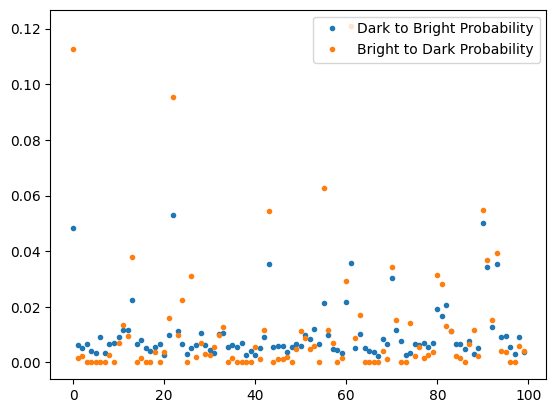

In [ ]:
plt.plot(pdb, '.', label="Dark to Bright Probability")
plt.plot(pbd, '.', label="Bright to Dark Probability")
plt.legend()

print(f"Average probability of dark to bright: {pdb.mean()}")
print(f"Average probability of bright to dark: {pbd.mean()}")


# TODO
* Automate testing and training for different hyperparameters
* Make multiple models to compare against each other
* Improve tweezer position finding algorithm
* Create fraction of dataset for testing data